This notebook (and script) contains full code to my participation in Rainforest Connection Species Audio Detection competition
https://www.kaggle.com/c/rfcx-species-audio-detection

* Competition is about classification of bird's sounds to 23 labels
* Train data contains 1100+ 1min sound files
* Each train file contains at least one type of bird with its label and time borders when the bird produce its sound (bird's sound is not present whole 60s, but only few particular seconds)
* Test set contains 1900+ 1min sound files and goal is to each sound file predict probabilites of existence of each 1 to 23 birds
* Competition metric is LWLRAP (multi class ranking metric)

Approach:
* Crop 10 seconds time window around each training data label 
* Create mel-spectograms from these sound chunks (https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53)
* Train CNN based on RESNETXXX with these mel-spectograms
* Divide 1 test file to 6 10 seconds chunks (0-10s, 10-20s,...,50-60s) and predict results to all chunks and aggregate afterwards (so called SED method). Same approach is also used for validation. 

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import StratifiedKFold, KFold

import torch
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

%run kaggle_functions.py

# Save all training data as mel-spectograms images
* 1) 10 second random(or center) crop around particular label
* 2) split 1 training file to 6 consequent 10 seconds chunks - this is for evaluation of valid files with same strategy as testing predictions


In [2]:
files = pd.read_csv("E:\\kaggle_data\\train\\_tp.csv")

path_train = "E:\\kaggle_data\\train"
path_to_save_train = "E:\\kaggle_data\\spectograms\\train_full"
path_to_save_valid = "E:\\kaggle_data\\spectograms\\valid_full"

file_length = 10
fmax = 15000

for index, row in files.iterrows():
    
    file_to_load = f"{files['recording_id'][index]}.flac"
    
    data, sr = load_audio(os.path.join(path_train, file_to_load))
    
    # crreating of spectogram from labeled crop
    spectogram = prepare_mel_spectogram(data,
                        sampling_rate = sr,
                        tmin = files['t_min'][index],
                        tmax = files['t_max'][index],
                        fmin = 90,
                        fmax = fmax, 
                        crop = 'center'                
                       )
    
    filename = f"{files['species_id'][index]}_{files['recording_id'][index]}_{int(round(files['t_min'][index]*10,0))}.png"
    fullpath = os.path.join(path_to_save_train, filename)
    cv2.imwrite(fullpath, spectogram)

    
    # creating of 6 spectograms from consequent 10-seconds chunks
    for start in np.arange(0, 60, file_length):
    
        spectogram = prepare_mel_spectogram(data,
                                            sampling_rate = sr,
                                            tmin = start,
                                            tmax = start + file_length,
                                            fmin = 90,
                                            fmax = fmax,
                                            crop = 'center'
                                           )
        filename = f"{file_to_load.split('.')[0]}_{start}.png"       
        fullpath = os.path.join(path_to_save_valid, filename)
        cv2.imwrite(fullpath, spectogram)
    
    
    #if index % 50 ==0:
    #    print(f"Proceeded {index} images out of {files.shape[0]}") 

# Saving testing set as 6x10s chunks mel-spectograms

In [3]:
file_length = 10 #split test file to file length seconds
path_test = "E:\\kaggle_data\\test"
test_files = os.listdir(path_test)
path_to_save = "E:\\kaggle_data\\spectograms\\test"
fmax = 15000

counter = 0
for file in test_files:  
    data, sr = load_audio(os.path.join(path_test, file))
    
    for start in np.arange(0, 60, file_length):
    
        spectogram = prepare_mel_spectogram(data,
                                            sampling_rate = sr,
                                            tmin = start,
                                            tmax = start + file_length,
                                            fmin = 90,
                                            fmax = fmax,
                                            crop = 'center')
        
        filename = f"{file.split('.')[0]}_{start}.png"
        
        fullpath = os.path.join(path_to_save, filename)
        cv2.imwrite(fullpath, spectogram)
    
    #if counter % 50 ==0:
    #    print(f"Proceeded {counter} images") 
    #counter = counter+1

# Target distribution

<AxesSubplot:>

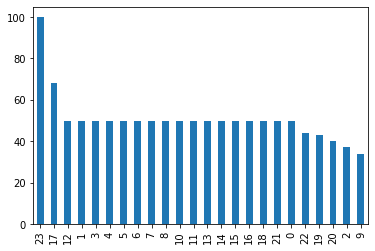

In [6]:
files = pd.read_csv("E:\\kaggle_data\\train\\_tp.csv")

files['species_id'].value_counts().plot(kind='bar')

# Plot 3 mel-spectograms with label 19

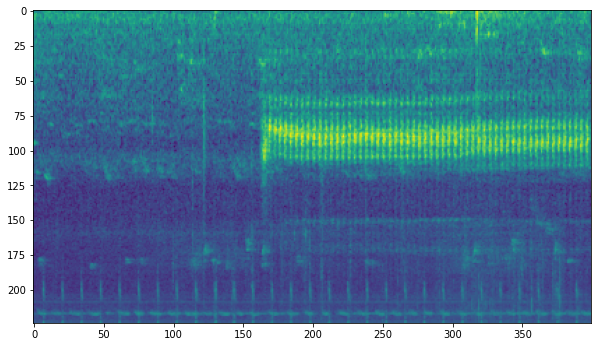

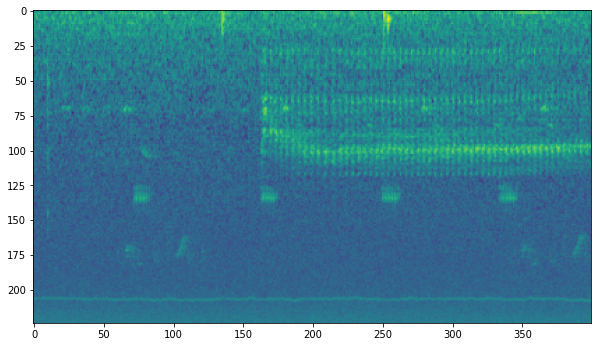

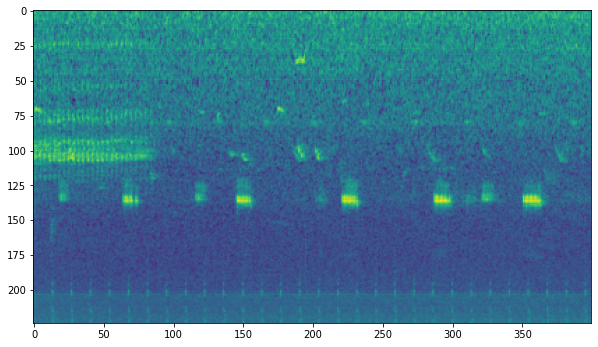

In [4]:

path_train = "E:\\kaggle_data\\spectograms\\train_full"

desired_index = 19   # images with this target should be plotted
image_number = 3    # first n images with this target will be plotted

print_images(path_train, desired_index, image_number)

# Plot 3 mel-spectograms with label 10

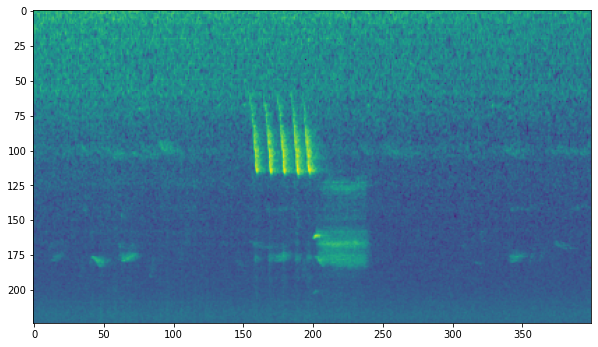

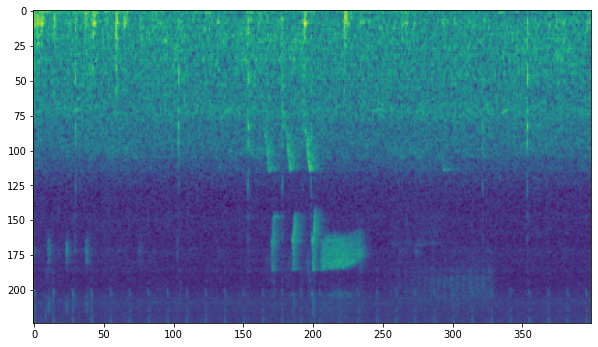

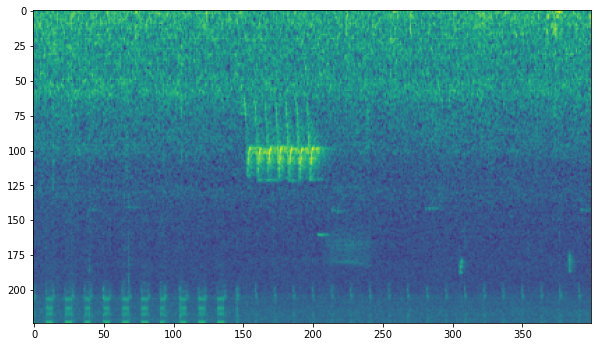

In [5]:
path_train = "E:\\kaggle_data\\spectograms\\train_full"

desired_index = 10 # images with this target should be plotted
image_number = 3    # first n images with this target will be plotted

print_images(path_train, desired_index, image_number)

# Resnet training and evaluation phase definition

In [8]:
def setlr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return optimizer

def lr_decay(optimizer, epoch):
    if epoch%8==0:
        new_lr = learning_rate / (10**(epoch//8))
        optimizer = setlr(optimizer, new_lr)
        print(f'Changed learning rate to {new_lr}')
    return optimizer



def train_model(model, criterion, optimizer, curr_fold, num_epochs, change_lr, evaluate_fake = False):

    # TRAIN PHASE
    train_loss = []
    valid_loss = []
    train_acc = []
    valid_acc = []
    train_LWLRAP = []
    valid_LWLRAP = []
    
    
    files = pd.read_csv("E:\\kaggle_data\\train\\_tp.csv")
    labs = []
    preds = []
    
    for i in range(0,24):
        labs.append(f's{i}_true')
        preds.append(f's{i}')
    
    for epoch in range(num_epochs):
        print('-----------------------------------')
        print(f'Epoch {epoch}/{num_epochs}')

        
        model.train() 
        #Tells the model to use train mode
        #Dropout layer behaves differently for train/eval phases
        
        actual_loss = 0
        num_corrects = 0
        
        if change_lr:
            optimizer = change_lr(optimizer, epoch)       
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device, dtype=torch.float)
            labels = labels.to(device, dtype=torch.float)
            
            optimizer.zero_grad() 
            # otherwise by calling loss.backward() gradient of parameters would be summed
            
            outputs = model(inputs) 
            
            loss = criterion(outputs, labels)     
            # creates graph of parameters, is connected to model throught outputs
        
            loss.backward()  #computes gradient of loss with respect to the parameters
            optimizer.step() #updates models parameters
            # it is possible to put optimizer.step and optimizer.zero(grad) out of batch for with slower conv
            
            actual_loss += loss.item() * inputs.size(0) #sum of losses for given batch
            num_corrects += torch.sum(outputs.argmax(dim=1) == labels.argmax(dim=1)).item() 

        train_loss.append(actual_loss / len(train_data)) 
        train_acc.append(num_corrects / len(train_data))

        print(f'train Loss: {round(train_loss[epoch],6)} Acc: {round(train_acc[epoch],6)} Num_corrects: {round(num_corrects,6)}/ {len(train_data)} ')
        
        
        #VALIDATION_PHASE
        
        with torch.no_grad(): # is it necessary?

            model.eval() 
            
            
            #computing LWLRAP everytime XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

            evaluated_data = score_and_extend(evaluate_path, model, list_train, files)
            actual_LWLRAP= LWLRAP(torch.Tensor(evaluated_data[preds].to_numpy()),
                            torch.Tensor(evaluated_data[labs].to_numpy()))    
            train_LWLRAP.append(actual_LWLRAP)
            print(f"TRAIN LWLRAP:{actual_LWLRAP}")
            
            evaluated_data = score_and_extend(evaluate_path, model, list_valid, files)
            actual_LWLRAP= LWLRAP(torch.Tensor(evaluated_data[preds].to_numpy()),
                            torch.Tensor(evaluated_data[labs].to_numpy()))    
            valid_LWLRAP.append(actual_LWLRAP)
            print(f"VALID LWLRAP:{actual_LWLRAP}")


            #XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
            

            if evaluate_fake == True:
            
                valid_actual_loss = 0
                valid_num_corrects = 0
        
                for inputs, labels in valid_loader:
                    inputs = inputs.to(device, dtype=torch.float)
                    labels = labels.to(device, dtype=torch.float)
            
                    outputs = model(inputs)               
                    loss = criterion(outputs, labels)
            
                    valid_actual_loss += loss.item() * inputs.size(0)
                    valid_num_corrects += torch.sum(outputs.argmax(dim=1) == labels.argmax(dim=1)).item()
            
                valid_loss.append(valid_actual_loss / len(valid_data))
                actual_acc = valid_num_corrects / len(valid_data)
                valid_acc.append(valid_num_corrects / len(valid_data))

                
                print(f'valid Loss: {round(valid_loss[epoch],6)} Acc: {round(valid_acc[epoch],6)} Num_corrects: {round(valid_num_corrects,6)}/ {len(valid_data)} ')
                    
    torch.save(model, f'E:\\kaggle_data\\saved_models\\model_{curr_fold}')
             
    if evaluate_fake == True:
        fig, axs = plt.subplots(2, figsize=(14,8))
        axs[0].plot(train_loss)
        axs[0].plot(valid_loss)
        axs[0].set_title('blue = Train Loss, orange = Valid Loss')

        axs[1].plot(train_LWLRAP)
        axs[1].plot(valid_LWLRAP)
        axs[1].set_title('Blue = Train LWLRAP, orange = Valid LWLRAP')
        plt.show()
    

# CV model training

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Starting fold 1
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Data loaded
-----------------------------------
Epoch 0/15
Changed learning rate to 0.0001


c:\Miniconda\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


train Loss: 0.052791 Acc: 0.085344 Num_corrects: 428/ 5015 


c:\Miniconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


TRAIN LWLRAP:0.5366259813308716
VALID LWLRAP:0.4726797640323639
valid Loss: 0.037217 Acc: 0.352113 Num_corrects: 75/ 213 
-----------------------------------
Epoch 1/15
train Loss: 0.035771 Acc: 0.179063 Num_corrects: 898/ 5015 
TRAIN LWLRAP:0.6563986539840698
VALID LWLRAP:0.5882428884506226
valid Loss: 0.022472 Acc: 0.516432 Num_corrects: 110/ 213 
-----------------------------------
Epoch 2/15
train Loss: 0.021116 Acc: 0.369691 Num_corrects: 1854/ 5015 
TRAIN LWLRAP:0.7585722804069519
VALID LWLRAP:0.682879626750946
valid Loss: 0.012155 Acc: 0.619718 Num_corrects: 132/ 213 
-----------------------------------
Epoch 3/15
train Loss: 0.012034 Acc: 0.562114 Num_corrects: 2819/ 5015 
TRAIN LWLRAP:0.7791669368743896
VALID LWLRAP:0.7203400135040283
valid Loss: 0.008894 Acc: 0.676056 Num_corrects: 144/ 213 
-----------------------------------
Epoch 4/15
train Loss: 0.007482 Acc: 0.73659 Num_corrects: 3694/ 5015 
TRAIN LWLRAP:0.8929173350334167
VALID LWLRAP:0.7868641018867493
valid Loss: 0.00

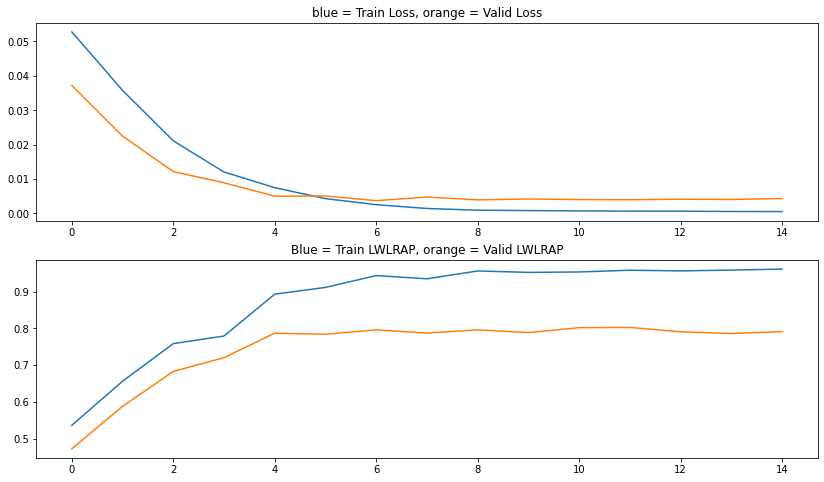

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Starting fold 2
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Data loaded
-----------------------------------
Epoch 0/15
Changed learning rate to 0.0001


c:\Miniconda\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


train Loss: 0.053265 Acc: 0.085542 Num_corrects: 426/ 4980 


c:\Miniconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


TRAIN LWLRAP:0.5063941478729248
VALID LWLRAP:0.4291720688343048
valid Loss: 0.037063 Acc: 0.295455 Num_corrects: 65/ 220 
-----------------------------------
Epoch 1/15
train Loss: 0.036648 Acc: 0.149598 Num_corrects: 745/ 4980 
TRAIN LWLRAP:0.5931704044342041
VALID LWLRAP:0.5580134391784668
valid Loss: 0.022511 Acc: 0.459091 Num_corrects: 101/ 220 
-----------------------------------
Epoch 2/15
train Loss: 0.021899 Acc: 0.285542 Num_corrects: 1422/ 4980 
TRAIN LWLRAP:0.6397488713264465
VALID LWLRAP:0.6003537774085999
valid Loss: 0.012134 Acc: 0.481818 Num_corrects: 106/ 220 
-----------------------------------
Epoch 3/15
train Loss: 0.012892 Acc: 0.500402 Num_corrects: 2492/ 4980 
TRAIN LWLRAP:0.8042758703231812
VALID LWLRAP:0.7378636002540588
valid Loss: 0.007331 Acc: 0.672727 Num_corrects: 148/ 220 
-----------------------------------
Epoch 4/15
train Loss: 0.007694 Acc: 0.727309 Num_corrects: 3622/ 4980 
TRAIN LWLRAP:0.8616491556167603
VALID LWLRAP:0.7808137536048889
valid Loss: 0.

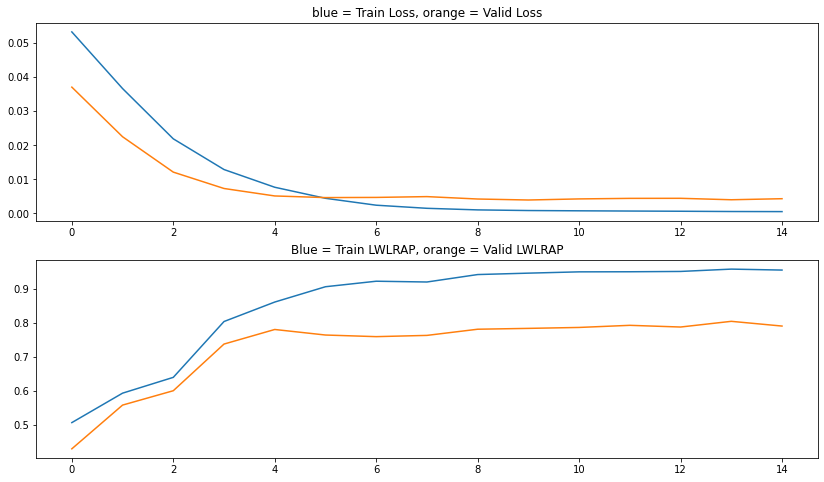

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Starting fold 3
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Data loaded
-----------------------------------
Epoch 0/15
Changed learning rate to 0.0001


c:\Miniconda\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


train Loss: 0.052714 Acc: 0.077355 Num_corrects: 386/ 4990 


c:\Miniconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


TRAIN LWLRAP:0.4728021025657654
VALID LWLRAP:0.39655813574790955
valid Loss: 0.035923 Acc: 0.293578 Num_corrects: 64/ 218 
-----------------------------------
Epoch 1/15
train Loss: 0.036056 Acc: 0.127856 Num_corrects: 638/ 4990 
TRAIN LWLRAP:0.5672677755355835
VALID LWLRAP:0.5075952410697937
valid Loss: 0.02371 Acc: 0.357798 Num_corrects: 78/ 218 
-----------------------------------
Epoch 2/15
train Loss: 0.021568 Acc: 0.28497 Num_corrects: 1422/ 4990 
TRAIN LWLRAP:0.607379138469696
VALID LWLRAP:0.5245542526245117
valid Loss: 0.013763 Acc: 0.40367 Num_corrects: 88/ 218 
-----------------------------------
Epoch 3/15
train Loss: 0.012148 Acc: 0.545691 Num_corrects: 2723/ 4990 
TRAIN LWLRAP:0.813494861125946
VALID LWLRAP:0.7314633727073669
valid Loss: 0.007068 Acc: 0.66055 Num_corrects: 144/ 218 
-----------------------------------
Epoch 4/15
train Loss: 0.006988 Acc: 0.757515 Num_corrects: 3780/ 4990 
TRAIN LWLRAP:0.883762538433075
VALID LWLRAP:0.7553168535232544
valid Loss: 0.006425 A

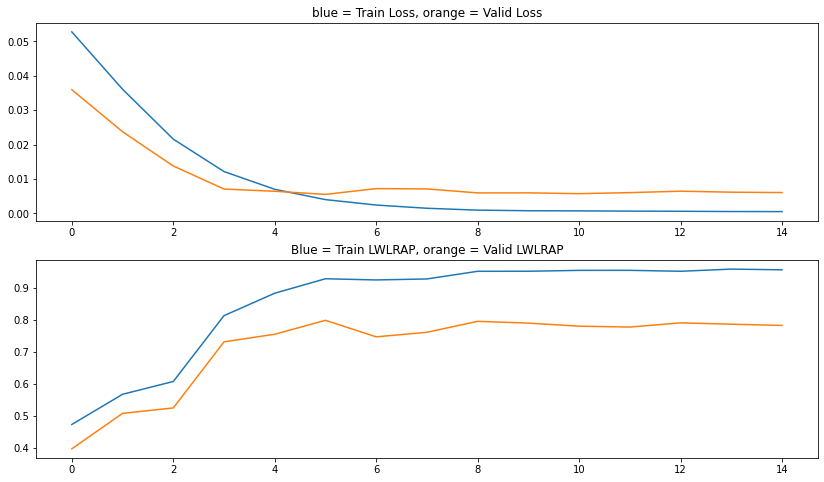

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Starting fold 4
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Data loaded
-----------------------------------
Epoch 0/15
Changed learning rate to 0.0001


c:\Miniconda\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


train Loss: 0.053007 Acc: 0.083417 Num_corrects: 415/ 4975 


c:\Miniconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


TRAIN LWLRAP:0.4616757929325104
VALID LWLRAP:0.38645339012145996
valid Loss: 0.035402 Acc: 0.248869 Num_corrects: 55/ 221 
-----------------------------------
Epoch 1/15
train Loss: 0.036687 Acc: 0.140101 Num_corrects: 697/ 4975 
TRAIN LWLRAP:0.5904777646064758
VALID LWLRAP:0.520969033241272
valid Loss: 0.023106 Acc: 0.420814 Num_corrects: 93/ 221 
-----------------------------------
Epoch 2/15
train Loss: 0.021785 Acc: 0.28603 Num_corrects: 1423/ 4975 
TRAIN LWLRAP:0.6803370118141174
VALID LWLRAP:0.5766716003417969
valid Loss: 0.012807 Acc: 0.506787 Num_corrects: 112/ 221 
-----------------------------------
Epoch 3/15
train Loss: 0.012836 Acc: 0.494472 Num_corrects: 2460/ 4975 
TRAIN LWLRAP:0.8004369139671326
VALID LWLRAP:0.7142376899719238
valid Loss: 0.007406 Acc: 0.647059 Num_corrects: 143/ 221 
-----------------------------------
Epoch 4/15
train Loss: 0.007354 Acc: 0.725226 Num_corrects: 3608/ 4975 
TRAIN LWLRAP:0.8902241587638855
VALID LWLRAP:0.7834314703941345
valid Loss: 0.00

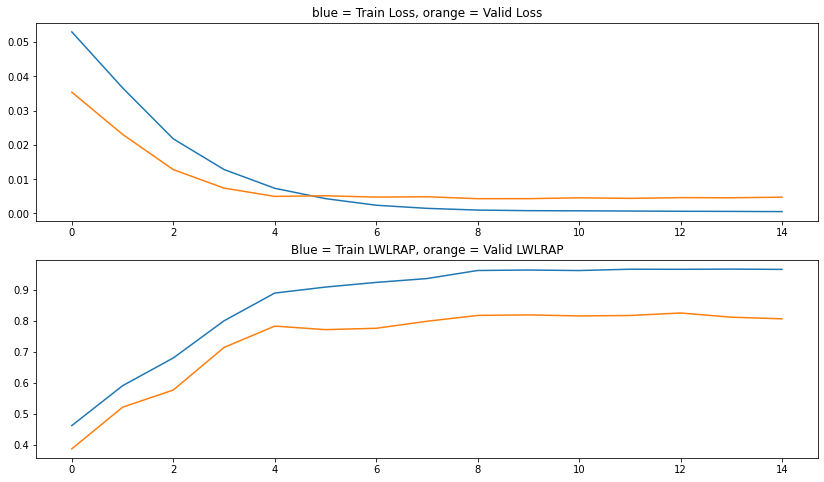

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Starting fold 5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Data loaded
-----------------------------------
Epoch 0/15
Changed learning rate to 0.0001


c:\Miniconda\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


train Loss: 0.052647 Acc: 0.079121 Num_corrects: 396/ 5005 


c:\Miniconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


TRAIN LWLRAP:0.44646626710891724
VALID LWLRAP:0.4037517011165619
valid Loss: 0.035269 Acc: 0.232558 Num_corrects: 50/ 215 
-----------------------------------
Epoch 1/15
train Loss: 0.036305 Acc: 0.118282 Num_corrects: 592/ 5005 
TRAIN LWLRAP:0.5691083669662476
VALID LWLRAP:0.4949641227722168
valid Loss: 0.022408 Acc: 0.367442 Num_corrects: 79/ 215 
-----------------------------------
Epoch 2/15
train Loss: 0.021786 Acc: 0.256543 Num_corrects: 1284/ 5005 
TRAIN LWLRAP:0.6622954607009888
VALID LWLRAP:0.581250011920929
valid Loss: 0.012205 Acc: 0.497674 Num_corrects: 107/ 215 
-----------------------------------
Epoch 3/15
train Loss: 0.013173 Acc: 0.476923 Num_corrects: 2387/ 5005 
TRAIN LWLRAP:0.7699388861656189
VALID LWLRAP:0.6971921920776367
valid Loss: 0.008143 Acc: 0.669767 Num_corrects: 144/ 215 
-----------------------------------
Epoch 4/15
train Loss: 0.008277 Acc: 0.673327 Num_corrects: 3370/ 5005 
TRAIN LWLRAP:0.8664722442626953
VALID LWLRAP:0.7837468981742859
valid Loss: 0.0

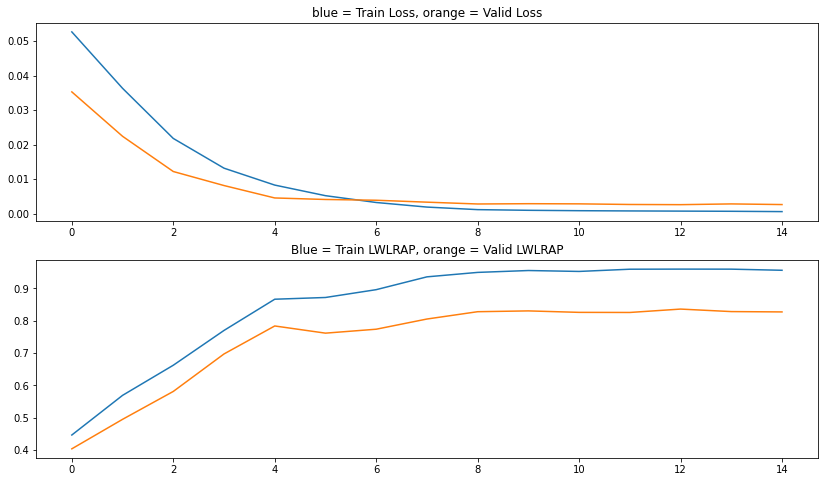

In [9]:
files = pd.read_csv("E:\\kaggle_data\\train\\_tp.csv")
path_train = "E:\\kaggle_data\\spectograms\\train_full"
evaluate_path = "E:\\kaggle_data\\spectograms\\valid_full"
num_classes=24

n_splits = 5
cross_val = StratifiedKFold(n_splits= n_splits, shuffle=True, random_state = 10)

valid_acc = []
valid_lwlrap = []

i = 0
for train_indexes, valid_indexes in cross_val.split(files['recording_id'], files['species_id']):
    print('XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX')
    print(f'Starting fold {i+1}')
    print('XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX')
    
    
    list_train = files['recording_id'][train_indexes].unique().tolist()
    list_valid = files['recording_id'][valid_indexes].unique().tolist()
    list_valid = [x for x in list_valid if x not in list_train] # remove from valid recording ids that are in both train and valid
    
    train_data = torch_dataset(list_train, path_train, num_classes, phase = 'train') 
    
    valid_data = torch_dataset(list_valid, path_train, num_classes, phase = 'valid')
    train_loader = DataLoader(train_data, batch_size=16, shuffle = True)
    valid_loader = DataLoader(valid_data, batch_size=16, shuffle = True)
    print('Data loaded')
    
    model_ft = return_nn(num_classes, device)
    
    learning_rate = 0.0001
    optimizer = torch.optim.Adam(model_ft.parameters(), lr=learning_rate)
    
    #loss_function = nn.BCEWithLogitsLoss()

    loss_function = FocalLoss()
    loss_function = loss_function.cuda()
    
    lwlrap = train_model(model_ft, loss_function, optimizer, i, 15, lr_decay ,evaluate_fake = True)
    #valid_acc.append(acc)
    valid_lwlrap.append(lwlrap)
    i = i+1
    

# SCORING OF TEST SET

In [ ]:
test_files = os.listdir("E:\\kaggle_data\\test")
test_files = [x.split('.')[0] for x in test_files]
test_path = "E:\\kaggle_data\\spectograms\\test"

result = score_images_test_set(test_path, test_files)
result.to_csv('E:\\kaggle_data\\submission.csv', header = True, index = False)